## Data Import

In [1]:
import numpy as np
import pandas as pd
import ast

data=pd.read_excel("https://docs.google.com/uc?id=1rwW3roc-ELRu-KDtau7NUz-GCF2M1yJJ")
for i in data.columns[6:9]:
  print(i)
  data[i] = data[i].apply(ast.literal_eval)
for i in data.columns[10:13]:
  print(i)
  data[i] = data[i].apply(ast.literal_eval)
print("type liste done")
df=data[data["avis_clean_final"].isnull()==False]
df=df[df["avis_clean_final_en"].isnull()==False]
data.head()

avis_token
avis_token_correct
avis_token_correct_sw
avis_token_en
avis_token_correct_en
avis_token_correct_en_sw
type liste done


,note,produit,assureur,date_com,date_xp,avis,avis_token,avis_token_correct,avis_token_correct_sw,avis_en,avis_token_en,avis_token_correct_en,avis_token_correct_en_sw,avis_clean_final,avis_clean_final_en
0,5,auto,Direct Assurance,2021-09-06,2021-09-21,"meilleurs assurances, prix, solutions, écoute,...","[meilleurs, assurances, prix, solutions, écout...","[meilleurs, assurances, prix, solutions, écout...","[meilleurs, assurances, prix, solutions, écout...","best insurance, price, solutions, listening, s...","[best, insurance, price, solutions, listening,...","[best, insurance, price, solutions, listening,...","[best, insurance, price, solutions, listening,...",meilleurs assurances prix solutions écoute rap...,best insurance price solutions listening speed...
1,4,auto,Direct Assurance,2021-05-03,2021-05-21,"je suis globalement satisfait , sauf que vous ...","[je, suis, globalement, satisfait, sauf, que, ...","[je, suis, globalement, satisfait, sauf, que, ...","[globalement, satisfait, sauf, problème, site,...","i am generally satisfied, except that you have...","[i, am, generally, satisfied, except, that, yo...","[i, am, generally, satisfied, except, that, yo...","[i, generally, satisfied, except, problem, web...",globalement satisfait sauf problème site inter...,i generally satisfied except problem website i...
2,5,auto,Direct Assurance,2021-03-21,2021-03-21,prix tres abordable plusieurs options s'offren...,"[prix, tres, abordable, plusieurs, options, s,...","[prix, tres, abordable, plusieurs, options, s,...","[prix, tres, abordable, plusieurs, options, of...",very affordable price several options are avai...,"[very, affordable, price, several, options, ar...","[very, affordable, price, several, options, ar...","[very, affordable, price, several, options, av...",prix tres abordable plusieurs options offrent ...,very affordable price several options availabl...
3,4,auto,L'olivier Assurance,2021-06-10,2021-06-21,"je satisfait du service, une réponse très rapi...","[je, satisfait, du, service, une, réponse, trè...","[je, satisfait, du, service, une, réponse, trè...","[satisfait, service, réponse, très, rapide, se...","i satisfy the service, a very fast response fr...","[i, satisfy, the, service, a, very, fast, resp...","[i, satisfy, the, service, a, very, fast, resp...","[i, satisfy, service, fast, response, service,...",satisfait service réponse très rapide service ...,i satisfy service fast response service i than...
4,1,auto,Matmut,2017-01-29,2017-01-21,"client depuis plus de 25 ans, très déçu de cet...","[client, depuis, plus, de, 25, ans, très, déçu...","[client, depuis, plus, de, 25, ans, très, déçu...","[client, depuis, plus, 25, ans, très, déçu, ce...","customer for more than 25 years, very disappoi...","[customer, for, more, than, 25, years, very, d...","[customer, for, more, than, 25, years, very, d...","[customer, 25, years, disappointed, mutual, lo...",client depuis plus 25 ans très déçu cette mutu...,customer 25 years disappointed mutual longer m...


# Bidirectional LSTM model

## data preparation

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import string

def clean_text(text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

data['description'] = data['avis'].apply(clean_text)

In [4]:
vocab_size = 30000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(data.description.values)
word_index = tokenizer.word_index

In [5]:
get_word = {v: k for k, v in word_index.items()}

In [6]:
sequences = tokenizer.texts_to_sequences(data.description.values[::100])

n_gram_sequences = []
for sequence in sequences:
    for i,j in enumerate(sequence):
        n_gram_sequences.append(sequence[:i + 1])
        
n_gram_sequences = np.array(n_gram_sequences)
max_len = max([len(i) for i in n_gram_sequences])    

<ipython-input-6-246ae1175cd2>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  n_gram_sequences = np.array(n_gram_sequences)


In [7]:
padded = pad_sequences(n_gram_sequences, maxlen = max_len, padding = 'pre')
input_seq, labels = padded[:,:-1], padded[:,-1]
labels = tf.keras.utils.to_categorical(labels, num_classes = vocab_size)

## Model 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten

model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 281, 64)           1920000   
                                                                 
 bidirectional (Bidirectiona  (None, 40)               13600     
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 30000)             1230000   
                                                                 
Total params: 3,163,600
Trainable params: 3,163,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(input_seq, labels, epochs=800, verbose=1)

Epoch 1/800
381/381 [==============================] - 59s 137ms/step - loss: 7.6535 - accuracy: 0.0413
Epoch 2/800
381/381 [==============================] - 23s 61ms/step - loss: 6.4785 - accuracy: 0.0419
Epoch 3/800
381/381 [==============================] - 14s 37ms/step - loss: 6.3071 - accuracy: 0.0418
Epoch 4/800
381/381 [==============================] - 14s 36ms/step - loss: 6.2074 - accuracy: 0.0433
Epoch 5/800
381/381 [==============================] - 11s 28ms/step - loss: 6.1363 - accuracy: 0.0478
Epoch 6/800
381/381 [==============================] - 12s 30ms/step - loss: 6.0693 - accuracy: 0.0519
Epoch 7/800
381/381 [==============================] - 11s 28ms/step - loss: 6.0106 - accuracy: 0.0557
Epoch 8/800
381/381 [==============================] - 10s 27ms/step - loss: 5.9606 - accuracy: 0.0601
Epoch 9/800
381/381 [==============================] - 9s 24ms/step - loss: 5.9139 - accuracy: 0.0617
Epoch 10/800
381/381 [==============================] - 10s 26ms/step - l

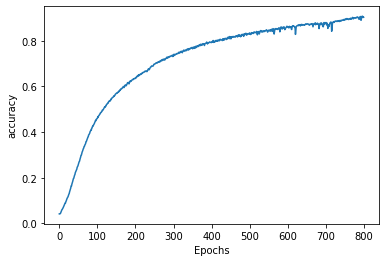

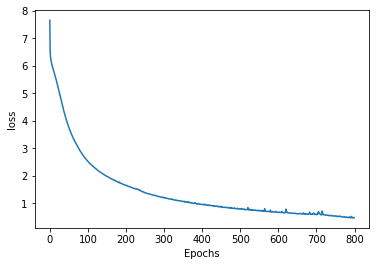

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Model 2

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout
from tensorflow.keras import regularizers


model2 = Sequential()
model2.add(Embedding(vocab_size, 100, input_length=max_len-1))
model2.add(Bidirectional(LSTM(150, return_sequences = True)))
model2.add(Dropout(0.2))
model2.add(LSTM(100))
model2.add(Dense(vocab_size/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(vocab_size, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(input_seq, labels, epochs=150, verbose=1)

Epoch 1/150
381/381 [==============================] - 67s 152ms/step - loss: 7.3179 - accuracy: 0.0388
Epoch 2/150
381/381 [==============================] - 57s 150ms/step - loss: 6.4260 - accuracy: 0.0433
Epoch 3/150
381/381 [==============================] - 57s 150ms/step - loss: 6.1986 - accuracy: 0.0504
Epoch 4/150
381/381 [==============================] - 57s 150ms/step - loss: 6.0617 - accuracy: 0.0518
Epoch 5/150
381/381 [==============================] - 57s 150ms/step - loss: 5.9562 - accuracy: 0.0521
Epoch 6/150
381/381 [==============================] - 57s 150ms/step - loss: 5.8743 - accuracy: 0.0583
Epoch 7/150
381/381 [==============================] - 57s 150ms/step - loss: 5.8065 - accuracy: 0.0598
Epoch 8/150
381/381 [==============================] - 57s 149ms/step - loss: 5.7420 - accuracy: 0.0680
Epoch 9/150
381/381 [==============================] - 57s 150ms/step - loss: 5.6857 - accuracy: 0.0719
Epoch 10/150
381/381 [==============================] - 57s 149m

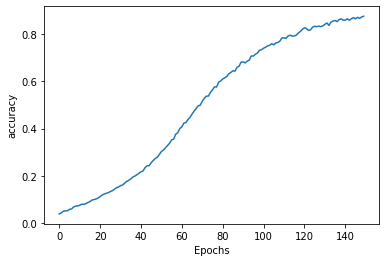

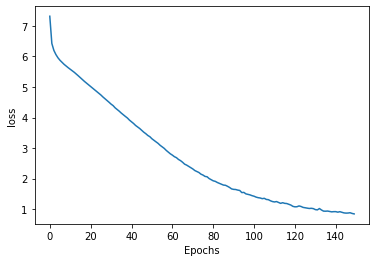

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

## Prediction Modèle 1

In [12]:
from tqdm import tqdm

def write_review(seed_text,size):
    for _ in tqdm(range(size)):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        pred_probs = model.predict(token_list,verbose=0)
        predicted=1
        while(predicted==1):
          predicted = np.random.choice(np.linspace(0, vocab_size - 1, vocab_size), p = pred_probs[0])
        output_word = get_word[predicted]
        seed_text += " " + output_word
    return seed_text

In [ ]:
print(write_review("rapide et",10))


100%|██████████| 10/10 [00:00<00:00, 17.28it/s]

rapide et bon troisième véhicule assuré chez april moto tarifs très compétitifs


## Prediction Modèle 2

In [15]:
from tqdm import tqdm

def write_review(seed_text,size):
    for _ in tqdm(range(size)):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        pred_probs = model2.predict(token_list,verbose=0)
        predicted=1
        while(predicted==1):
          predicted = np.random.choice(np.linspace(0, vocab_size - 1, vocab_size), p = pred_probs[0])
        output_word = get_word[predicted]
        seed_text += " " + output_word
    return seed_text


print(write_review("génial, très bon rapport qualité",15))
print(write_review("horrible, que des problèmes",15))

100%|██████████| 15/15 [00:02<00:00,  6.62it/s]


génial, très bon rapport qualité prix tarif personnel accessible conseil à lécoute de conseil mais mont appelé du 1er mois


100%|██████████| 15/15 [00:01<00:00, 13.03it/s]

horrible, que des problèmes mais avec 1 papier non en janvier 2017 je change de ne pas résilier de


# GPT text generation with KerasNLP
*source : https://keras.io/examples/generative/text_generation_gpt/*


## Setup

In [ ]:
!pip install --upgrade keras-nlp tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import keras_nlp
import tensorflow as tf
from tensorflow import keras

## Settings & hyperparameters

In [ ]:
# Data
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 250

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 15000

# Training
EPOCHS = 10

# Inference
NUM_TOKENS_TO_GENERATE = 80

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data, test_size=0.2)

np.savetxt(r'train.txt', train_df["avis_en"].tolist(), fmt='%s')
np.savetxt(r'valid.txt', val_df["avis_en"].tolist(), fmt='%s')

In [ ]:
raw_train_ds = (
    tf.data.TextLineDataset("train.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

raw_val_ds = (
    tf.data.TextLineDataset("valid.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
)

## Train the tokenizer


In [ ]:
# Train tokenizer vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

## Load tokenizer


In [ ]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

## Tokenize data


In [ ]:
# packer adds a start token
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)


def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

## Build the model


In [ ]:
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
# Embedding.
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        3872768   
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_decoder_12 (Tra  (None, None, 256)        394749    
 nsformerDecoder)                                                
                                                                 
 transformer_decoder_13 (Tra  (None, None, 256)        394749    
 nsformerDecoder)                                                
                                                                 
 dense_6 (Dense)             (None, None, 15000)       3855

## Training

In [ ]:
model.fit(train_ds, validation_data=val_ds, verbose=2, epochs=EPOCHS)

Epoch 1/10
95/95 - 30s - loss: 6.5048 - perplexity: 675.6003 - val_loss: 6.2403 - val_perplexity: 519.4368 - 30s/epoch - 317ms/step
Epoch 2/10
95/95 - 15s - loss: 6.2301 - perplexity: 514.0461 - val_loss: 6.2400 - val_perplexity: 519.4834 - 15s/epoch - 154ms/step
Epoch 3/10
95/95 - 15s - loss: 6.2249 - perplexity: 511.5698 - val_loss: 6.0983 - val_perplexity: 452.0026 - 15s/epoch - 155ms/step
Epoch 4/10
95/95 - 16s - loss: 5.5517 - perplexity: 262.5005 - val_loss: 5.0038 - val_perplexity: 151.8748 - 16s/epoch - 165ms/step
Epoch 5/10
95/95 - 16s - loss: 4.7522 - perplexity: 118.0320 - val_loss: 4.7061 - val_perplexity: 112.7710 - 16s/epoch - 165ms/step
Epoch 6/10
95/95 - 16s - loss: 4.4806 - perplexity: 89.8962 - val_loss: 4.5975 - val_perplexity: 101.0479 - 16s/epoch - 167ms/step
Epoch 7/10
95/95 - 15s - loss: 4.2805 - perplexity: 73.5167 - val_loss: 4.5580 - val_perplexity: 97.3434 - 15s/epoch - 159ms/step
Epoch 8/10
95/95 - 15s - loss: 4.1208 - perplexity: 62.6295 - val_loss: 4.4580 

## Inference


In [ ]:
prompt_tokens = tf.convert_to_tensor([tokenizer.token_to_id("[BOS]")])

def token_logits_fn(inputs):
    cur_len = inputs.shape[1]
    output = model(inputs)
    return output[:, cur_len - 1, :]  # return next token logits


In [ ]:
output_tokens = keras_nlp.utils.top_p_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
    p=0.5,
    from_logits=True,
)

print("generated review:")
tf.print(tokenizer.detokenize(output_tokens))


generated review:
[BOS] i have been assured at my maaf for over thirty years . . . . . . i have just received a quote from june and i have always been a serious . i have no response to my emails and telephone calls . i have no response . . . i will have an information on my phone . i have no news . . . i have an accident indinary assurance . . i have


# Chat-GPT - Unofficial API

In [ ]:
%%capture

!pip install pyChatGPT
!apt install chromium-browser xvfb
!pip install -U selenium_profiles pyChatGPT

from selenium_profiles.utils.installer import install_chromedriver
install_chromedriver()

from pyChatGPT import ChatGPT

In [ ]:
session_token = 'eyJhbGciOiJkaXIiLCJlbmMiOiJBMjU2R0NNIn0.._gldwcE522e1XRYa.TwCy7FlVJL30MrgMGqgtCJu2T6qMzf7fgPXbBxDVjsZ60rZrNYKslJCAptatmYr2easGJ6caYlOReTxjJgixKs6rOW5shVZMjTojzK3aJtM04dB2jQL-2fcLPWkuTcBVH-KrQ7gj5YP7Ec-6n3vDlJmtbp4Xnl82pr0BuUSorRfSHj5V1WHGJvRSw7fqjoC9eW3hj12V4N4uV92NhyiG10wx5DG_C7PxIIRHChOIT8jLl_2vjbhzVf6uM--bW_fDStyNUV5KohuT9GXEale6c2__K415zMVgQCY7f7FEXf30s7Kb4zGzpcuyrwBgRy8eKWwIPn_YFR4_UM9eE_9mPFZtPiHs5qepU5xAdTBtAyYo4KMDRJVS4rfaazfqKrOq26LDoo5zEOwk6v7gNHTdeqpGfIATmUxjz-vVo0pk-rteHd6GdRCM7SRkjH4CjsXPnAUd69tllTEyWRLwVIShkEiDXTE19qrmJLKyi1l0TR4LxRBxNfQhNrNAT0hu7s5D6mRMT9tpYtgwMB0WyJhstIdRSYi_6PMKt6k1lxo1M7341LZSmSAOlq55bjr1YDFOh_eCDaVA3u949qpO4zMFKd6G2fw0GQNVG2yC-KGdAzXq0P-GFc14yV1qoDQtQEeUdVA4KchE1waFZ2_XS1GXbnc6wqiwcEJ8rMLSPMtUBzqd4WbecoHEEZk89MT9lh-oMYueRfRo0g6vdcUtwqgUHeVg3TMFtgEcpUHt5QXqSchxoDtDcTY5voA-lTWZKIfUkBOEk4jOYjOFlyh318Je2wIL6nkzdjbhKJFbPe5zvSBEvOHYubzPwesc3OJL0wdu8OyaX7LkPcJ8mLgdWIffG1rG696UwOSX0UG0D9GqjvjNGJYK_Hs737bueqbXFf6p4kJ9RgrGFd1yjZ7ibmYSHYPtoAV2mQpVTdZ7Uo7L6SQTK4pc1Hl9PdK0fXvw5XZACtCzg73ta1k-PwsQtJFiibaeSAtHYQjTUtWwXc7_oL4-bubhJboCUZhNT0AKMFQHtMqEa2Rn5LUtG2f97sInSIahyMAaoRDBMmQvmiGL3PdteFt3NCzWrQkY09hFEfj12-Xrv6e3C8kHGUY5sTmiTiZHlBiEeTVp7yu2XTW51i211zWzRFSmFbg1Wg5FIkA-p91RAgP3sgZ5GILjjYd9QEM4Ch0R9zcXa4DLjO2xn89kz5tKO1HcWfw3e72jnzba3K5S8Nu4I1G15O3_EX5dVwSEavGLpKKMwVACTNXNjbiC2weNqSP3GVnNF2D5gB8Dlrss6ZxyBBsSRoUfIqW3bW0Z7zU9bFdy7MuP2-946JjSimagZRpdCBY74Cneueb3eENzP8pIKkg03m4bNwWIJkPzqOUXGdSUJR8mJyzeNEUuA7xS3Fe4Lf1Zb7Qat8xnW6WTIhdy_icgjY1IBk1B0opYBmtB5serj0QK6E9iwyl_FD7l0t2ZaudtCVueRfaSx_I7WaXjTtCahKtoZ-ZGfLs_q-BZSepPE95_UZdgsgs6-9FfmDziSNIjHUl0aO6ga8h5FELPg2iFyE-Yu-chbOhQGViDuKxFxCENa13CtjrhuaQeWfk7V1YFwA1Da3polQw11bCi6lP98AS7KYPgHseROot782PI0BxkFzJFjtm4dL6_WXencjX56ZQs-xfr_fjAxpacZFuBNOZszcIU15ocQnYs5UZMMJibVMIDOmw6DXKY3POr0pqg4L8t06gdY16ezWU7vF_Fpktpf7I-wSwdQ85vyYvz-pgaZNXoIreFMoJvMrZXHNVBza_f-0p9G34Ig4q51KHpk4R1WBk9jlHi2UbBvqViOKIzLnqZbahBZSfTcfVipivbCVV7SQ7hl7OQFw4wNV3m5IjEHHR1BBAQuR7aB1j9HA9-vvgbueRNLm4wW4fgajTto044BxVqduFpfIHVA3i4CcfRo6QlbungULhALzL3CrqXWC1xfCcsTzc2jKDwAjUdxXZs3uSAp0Q-s9kQH_Jagqi3iW2sxBaNoO8HJJ5xb5lvTLScqlFIc0UcDaejfSSmsERkH8-dMJKqmsz4IQaKEk_CWB56_T6HTVuUEJhuTpIaKp35tnF6T8j-U5UbRYUhv7cgtT_c6ayodiuoJj1_096OhzKimqMINtvdFQdsot_q9OKMAgpy7qAI8bXv820L3VMahe-AMbJuf_MvraNismt-1NSw5uM9IWz5roGD7bTLXFZ782irGQ-RjPjwytIcqomsHiMfoPSkUFUZIC6mFkMV2FoKS9aPD0aUvMtbCy4lkGvz-18kHCcgtfd6womZAYSkkLPwy75n4j9g1258iFrfKIVFr63jfZ8eiFti-WvF9VSzjJ-ZvHYw5hNhspm6MnmjCwi_Dg6zw4DZIqUOkqT6.AuDAy0dHIc5QfIZI1168VA'
api = ChatGPT(session_token) 
nb_assur=5
resp = api.send_message(f"écrit moi sans aucune autres informations {str(nb_assur)} courtes reviews d'assurance auto, santé ou vie")

1. J'ai souscrit une assurance auto chez XYZ et jusqu'à présent, j'ai été très satisfait de leur service. Les délais de traitement de mes demandes ont été courts et leur personnel a été toujours très professionnel et attentif à mes besoins.
2. Mon assurance santé chez ABC m'a vraiment sauvé la vie cette année. J'ai dû être hospitalisé pour une intervention chirurgicale imprévue et ils ont pris en charge tous les frais de manière efficace et sans tracas. Je suis vraiment reconnaissant pour leur soutien et leur couverture solide.
3. J'ai récemment changé d'assurance vie pour passer à DEF et je suis ravi de mon choix. Le processus de souscription a été rapide et facile et j'ai été impressionné par leur large gamme de options de couverture. Je me sens en sécurité sachant que ma famille est protégée en cas d'imprévu.
4. Mon expérience avec GHI pour mon assurance auto a été décevante. Leur processus de réclamation a été lent et compliqué et j'ai eu du mal à obtenir des réponses à mes questio

In [ ]:
import re
review=[review.replace("\n","") for review in re.split("\d+. ",resp['message'])[1:]]
review

["J'ai souscrit une assurance auto chez XYZ et jusqu'à présent, j'ai été très satisfait de leur service. Les délais de traitement de mes demandes ont été courts et leur personnel a été toujours très professionnel et attentif à mes besoins.",
 "Mon assurance santé chez ABC m'a vraiment sauvé la vie cette année. J'ai dû être hospitalisé pour une intervention chirurgicale imprévue et ils ont pris en charge tous les frais de manière efficace et sans tracas. Je suis vraiment reconnaissant pour leur soutien et leur couverture solide.",
 "J'ai récemment changé d'assurance vie pour passer à DEF et je suis ravi de mon choix. Le processus de souscription a été rapide et facile et j'ai été impressionné par leur large gamme de options de couverture. Je me sens en sécurité sachant que ma famille est protégée en cas d'imprévu.",
 "Mon expérience avec GHI pour mon assurance auto a été décevante. Leur processus de réclamation a été lent et compliqué et j'ai eu du mal à obtenir des réponses à mes quest